In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import os

/home/waldir/miniforge3/envs/tf115/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt

In [3]:
pred_df = pd.read_parquet('pred_df_128_8_8.parquet')

In [4]:
pred_df.shape

(77284, 12)

In [5]:
pred_df.head(3)

,enroll_sess,auth_sess,enroll_user,enroll_camera_label,enroll_user_device_camera,auth_user,auth_camera_label,auth_user_device_camera,is_same_user,is_same_camera_label,is_same_user_device_camera,similarity
0,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,True,True,True,0.871620
1,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871501815_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,True,True,True,0.896249
2,ahmed.atef@keyless.io_1750871273156_1.0.8,ahmed.atef@keyless.io_1750871561316_1.0.8,ahmed.atef@keyless.io,Camo,ahmed.atef@keyless.io___79a3a0040ddba27de980b1...,ahmed.atef@keyless.io,Fantech Luminous C30 (1d6c:1278),ahmed.atef@keyless.io___01d1c987f5595b61ccf52e...,True,False,False,0.704820


<AxesSubplot:>

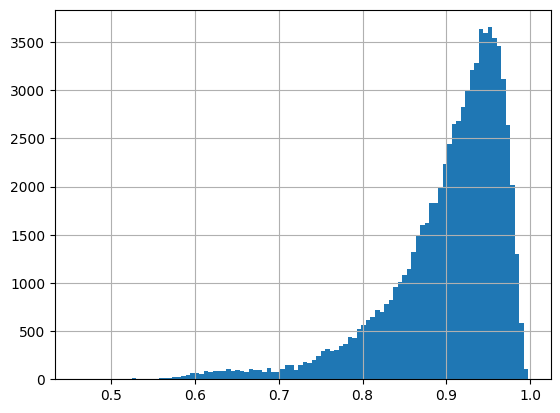

In [6]:
pred_df.similarity.hist(bins=100)
# plt.axvline(x=0.5, color='red', linestyle='--', linewidth=1)

In [7]:
def get_FAR_FRR(df, thr=0.5, pred_col='similarity', target_col='is_same_user_device_camera'):
    targets = df[target_col]
    pred_proba = df[pred_col]
    
    preds = pred_proba > thr
    TP = sum((targets == True) & (preds == True))
    FP = sum((targets == False) & (preds == True))
    TN = sum((targets == False) & (preds == False))
    FN = sum((targets == True) & (preds == False))

    FAR = FP / (TN + FP)
    FRR = FN / (TP + FN)

    # print(f'FAR: {FAR:.1%}')
    # print(f'FRR: {FRR:.1%}')
    return FAR, FRR


In [8]:

fars = []
frrs = []
for t in np.arange(0, 1, 0.01):
    far, frr = get_FAR_FRR(pred_df, t)
    fars.append(far)
    frrs.append(frr)


In [9]:
def get_closest_to_far(target_far, fars, frrs):
    idx = (np.array(fars) < target_far).argmax()
    return fars[idx], frrs[idx]

def get_closest_to_frr(target_frr, fars, frrs):
    idx = (np.array(frrs) > target_frr).argmax()
    print(idx)
    return fars[idx], frrs[idx]

88


Text(0.5, 1.0, '9.6% FRR @ 60.7% FAR')

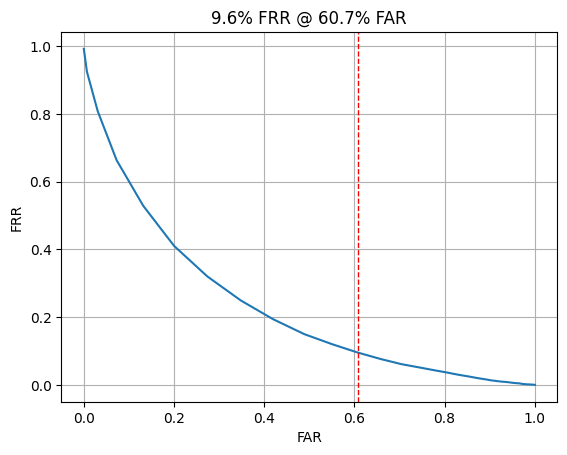

In [10]:

target_frr = 0.08
sel_far, sel_frr = get_closest_to_frr(target_frr, fars, frrs)

plt.plot(fars, frrs)
plt.xlabel('FAR')
plt.ylabel('FRR')
plt.grid()
plt.axvline(x=sel_far, color='red', linestyle='--', linewidth=1)
plt.title(f'{sel_frr:.1%} FRR @ {sel_far:.1%} FAR')